In [2]:
import os

In [3]:
if not os.path.exists("data"):
  !wget -q https://www.dropbox.com/s/4f314zcoo0lvlzn/Brain%20Tumor%20Segmentation.zip?dl=0 --output-document tumor_dataset.zip
  !unzip -q tumor_dataset.zip
  !rm tumor_dataset.zip
  !pip install -q torch_snippets pytorch_model_summary
  !pip install -U segmentation-models-pytorch albumentations --user 
  !pip install segmentation_models_pytorch==0.2.1
  !pip install tensorflow==2.1.0
  !pip install keras==2.3.1

replace data/images/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached segmentation_models_pytorch-0.3.2-py3-none-any.whl (106 kB)
  Using cached timm-0.6.12-py3-none-any.whl (549 kB)
  Using cached efficientnet_pytorch-0.7.1-py3-none-any.whl
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached segmentation_models_pytorch-0.2.1-py3-none-any.whl (88 kB)
  Using cached efficientnet_pytorch-0.6.3-py3-none-any.whl
  Using cached timm-0.4.12-py3-none-any.whl (376 kB)
  Attempting uninstall: efficientnet-pytorch
    Found existing installation: efficientnet-pytorch 0.7.1
    Uninstalling efficientnet-pytorch-0.7.1:
      Successfully uninstalled efficientnet-pytorch-0.7.1
  Attempting uninstall: timm
    Found existing installation: timm 0.6.12
    Uninstalling timm-0.6.12:
      Successfully uninstalled timm-0.6.12
  Attem

In [4]:

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [5]:
import albumentations as albu

In [6]:
from torchsummary import summary

In [7]:
import numpy as np
from skimage import color
import segmentation_models_pytorch as smp

In [8]:
data_dir = "data"
image_dir_name = "images"
mask_dir_name = "masks"
image_dir = os.path.join(data_dir,image_dir_name)
mask_dir = os.path.join(data_dir,mask_dir_name)

In [9]:
images = Glob(os.path.join(image_dir,"*.png"))
masks = Glob(os.path.join(mask_dir, "*.png"))

In [10]:
print(len(images), len(masks))

3064 3064

# Visualizations

In [11]:
img = read(images[0],1)

In [12]:
img.shape

(512, 512, 3)

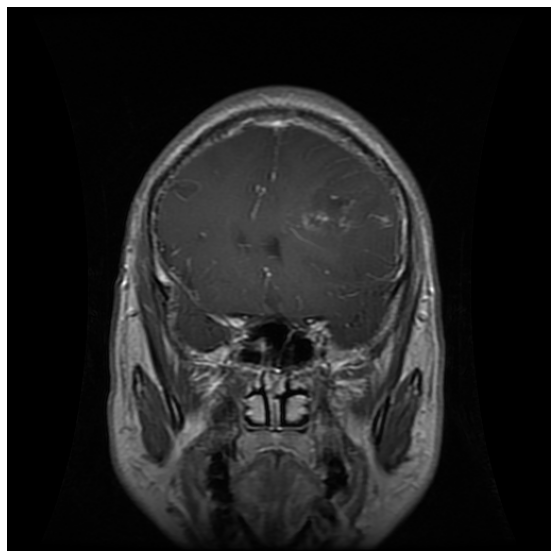

In [13]:
show(img)

In [14]:
msk = read(masks[0])


(512, 512)

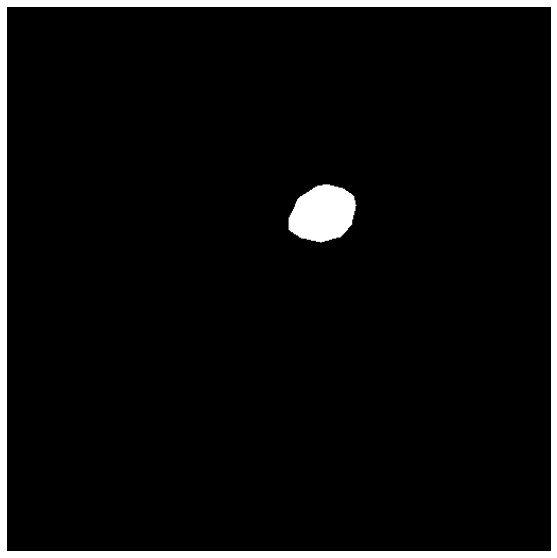

In [15]:
print(msk.shape)
show(msk)

In [16]:
msk = np.stack((msk,msk,msk),axis = 2)

In [17]:
overlayed_img = np.where(msk, (255,0,0), img) # Red overlay (255,0,0)

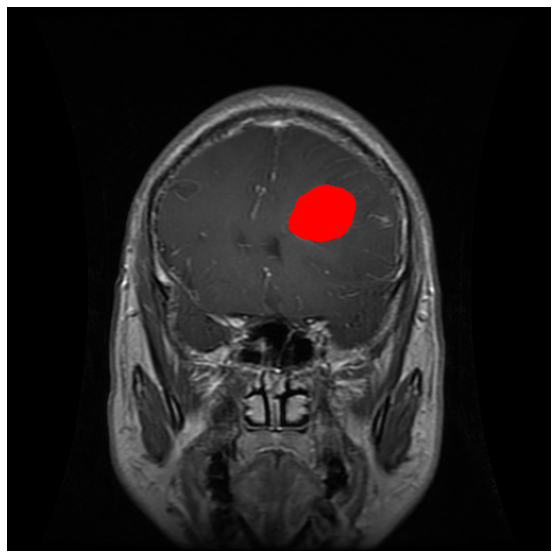

In [18]:
show(overlayed_img)

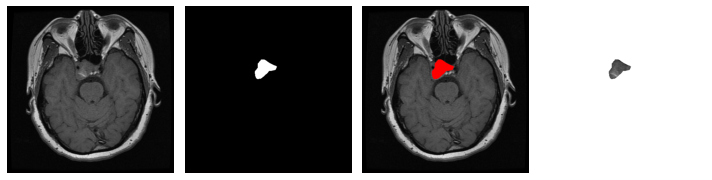

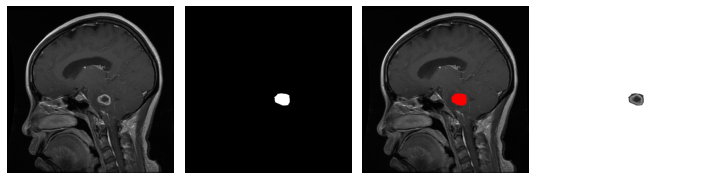

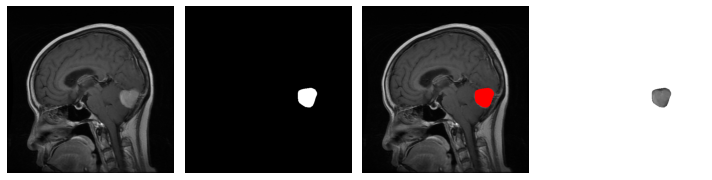

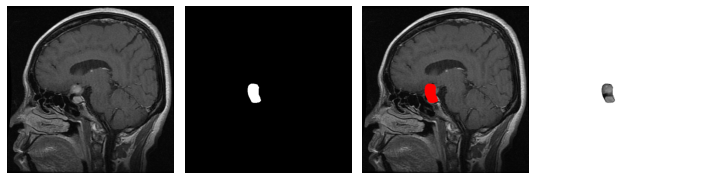

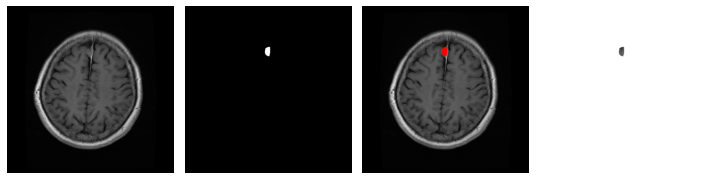

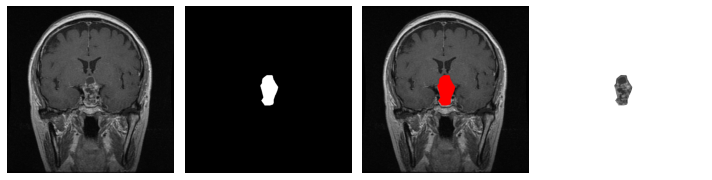

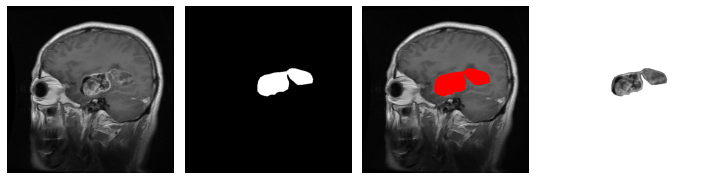

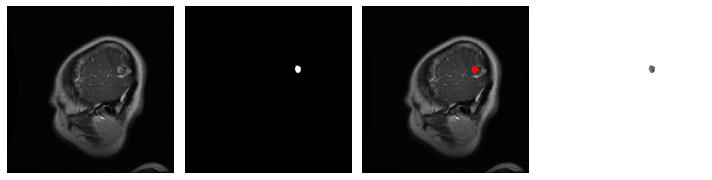

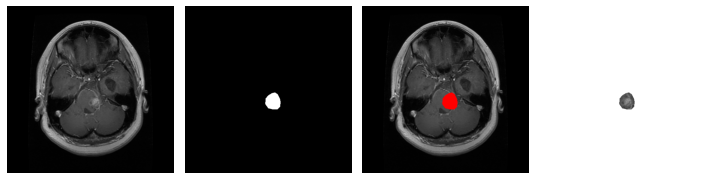

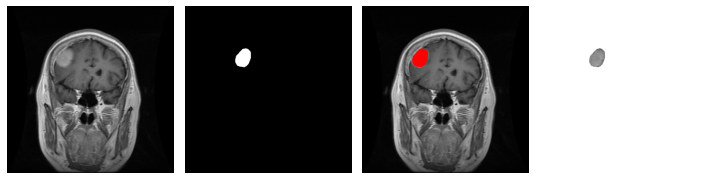

In [19]:

for i in range(10):
  index = np.random.choice(len(images))
  img = read(images[index],1)
  msk = read(masks[index])
  msk_stack = np.stack((msk,msk,msk),axis = 2)
  overlayed_img = np.where(msk_stack, (255,0,0), img) # Red overlay (255,0,0)

  rgba = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
  rgba[:, :, 3] = msk
  subplots([img,msk, overlayed_img, rgba], figsize = (10,10))


# Training and Validation Split

In [20]:
combined = list(zip(images,masks))

In [21]:
trn_files, val_files = train_test_split(combined, random_state = 42,test_size=0.2)

# DataSet class

In [22]:
os.cpu_count()

2

In [23]:
# Image Transformation object
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [24]:
mask_tfms = transforms.ToTensor()

In [25]:
class BrainTumorDataset(Dataset):
  def __init__(self, items, preprocessing = None):
    self.items = items
    self.preprocessing = preprocessing

  def __len__(self):
    return len(self.items)

  def __getitem__(self, ix):
    item = self.items[ix]
    
    ## Getting image and mask path
    image_path = item[0]
    mask_path = item[1]
    
    ### Ingesting image and mask 
    image = read(image_path,1)
    mask = read(mask_path)

    ### resizing image and mask to 224,224. Will start with vgg16 backbone
    image = cv2.resize(image, (224,224))
    mask = cv2.resize(mask, (224,224))
    
    ## Adding depth dimension as image is greyscale
    mask = mask[...,np.newaxis]
    
    # apply preprocessing
    if self.preprocessing:
      sample = self.preprocessing(image = image, mask = mask)
      image, mask = sample['image'], sample['mask']
      

    return image, mask

  # def collate_fn(self,batch):
  #   ims, masks = list(zip(*batch))
  #   #print(ims)
  #   ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)

  #   ###########  Changing mask to float
  #   #ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).float().to(device)
  #   ce_masks = torch.cat([mask_tfms(mask.copy()/255.)[None] for mask in masks]).float().to(device)
    
  #   return ims, ce_masks

  def choose(self):
    return self[randint(len(self))]







In [26]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [27]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [28]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DEVICE = device
CLASSES = ['tumor']
preprocessing_fn  = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [29]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [30]:
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [31]:
train_ds = BrainTumorDataset(items=trn_files, preprocessing = get_preprocessing(preprocessing_fn))


In [32]:
temp_img, temp_msk = train_ds[0]

In [33]:
temp_img.shape

(3, 224, 224)

In [34]:
temp_msk.shape

(1, 224, 224)

In [35]:
valid_ds  =  BrainTumorDataset(items=val_files, preprocessing = get_preprocessing(preprocessing_fn))


In [36]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_ds, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [37]:
loss = smp.losses.DiceLoss(mode = 'binary')

In [69]:
def IOU_Score(output,target,mode = 'binary',threshold = 0.5):
  tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode=mode, threshold=threshold)
  iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
  return iou_score

In [38]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])


In [39]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [40]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

Epoch: 0

train:   0%|          | 0/307 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


valid:   0%|          | 0/613 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


valid: 100%|██████████| 613/613 [00:20<00:00, 30.24it/s, dice_loss - -0.8737, iou_score - 30.3]


Model saved!

Epoch: 1

valid: 100%|██████████| 613/613 [00:21<00:00, 28.62it/s, dice_loss - -0.9083, iou_score - 42.38]


Model saved!

Epoch: 2

valid: 100%|██████████| 613/613 [00:19<00:00, 31.63it/s, dice_loss - -0.9192, iou_score - 54.37]


Model saved!

Epoch: 3

valid: 100%|██████████| 613/613 [00:20<00:00, 30.22it/s, dice_loss - -0.9126, iou_score - 44.38]


Epoch: 4

valid: 100%|██████████| 613/613 [00:19<00:00, 30.81it/s, dice_loss - -0.9344, iou_score - 71.98]


Model saved!

Epoch: 5

valid: 100%|██████████| 613/613 [00:19<00:00, 31.10it/s, dice_loss - -0.9402, iou_score - 67.01]


Epoch: 6

valid: 100%|██████████| 613/613 [00:19<00:00, 30.91it/s, dice_loss - -0.9388, iou_score - 70.14]


Epoch: 7

valid: 100%|██████████| 613/613 [00:19<00:00, 31.87it/s, dice_loss - -0.9397, iou_score - 75.78]


Model saved!

Epoch: 8

valid: 100%|██████████| 613/613 [00:19<00:00, 30.69it/s, dice_loss - -0.9247, iou_score - 69.5]


Epoch: 9

valid: 100%|██████████| 613/613 [00:18<00:00, 32.36it/s, dice_loss - -0.9427, iou_score - 81.06]


Model saved!

Epoch: 10

valid: 100%|██████████| 613/613 [00:19<00:00, 32.10it/s, dice_loss - -0.9369, iou_score - 75.71]


Epoch: 11

valid: 100%|██████████| 613/613 [00:19<00:00, 31.55it/s, dice_loss - -0.9385, iou_score - 84.11]


Model saved!

Epoch: 12

valid: 100%|██████████| 613/613 [00:19<00:00, 30.88it/s, dice_loss - -0.9366, iou_score - 82.99]


Epoch: 13

valid: 100%|██████████| 613/613 [00:19<00:00, 30.91it/s, dice_loss - -0.9386, iou_score - 85.73]


Model saved!

Epoch: 14

valid: 100%|██████████| 613/613 [00:21<00:00, 28.42it/s, dice_loss - -0.9441, iou_score - 83.49]


Epoch: 15

valid: 100%|██████████| 613/613 [00:20<00:00, 30.14it/s, dice_loss - -0.9455, iou_score - 88.83]


Model saved!

Epoch: 16

valid: 100%|██████████| 613/613 [00:20<00:00, 30.47it/s, dice_loss - -0.9393, iou_score - 81.01]


Epoch: 17

valid: 100%|██████████| 613/613 [00:19<00:00, 32.12it/s, dice_loss - -0.9369, iou_score - 98.41]


Model saved!

Epoch: 18

valid: 100%|██████████| 613/613 [00:22<00:00, 27.79it/s, dice_loss - -0.9376, iou_score - 96.9]


Epoch: 19

valid: 100%|██████████| 613/613 [00:20<00:00, 29.63it/s, dice_loss - -0.9412, iou_score - 86.12]


Epoch: 20

valid: 100%|██████████| 613/613 [00:21<00:00, 27.87it/s, dice_loss - -0.9362, iou_score - 75.53]


Epoch: 21

valid: 100%|██████████| 613/613 [00:19<00:00, 31.09it/s, dice_loss - -0.9473, iou_score - 87.84]


Epoch: 22

valid: 100%|██████████| 613/613 [00:20<00:00, 30.07it/s, dice_loss - -0.9452, iou_score - 92.83]


Epoch: 23

valid: 100%|██████████| 613/613 [00:18<00:00, 32.35it/s, dice_loss - -0.9398, iou_score - 101.0]


Model saved!

Epoch: 24

valid: 100%|██████████| 613/613 [00:20<00:00, 29.82it/s, dice_loss - -0.9328, iou_score - 98.48]


Epoch: 25

valid: 100%|██████████| 613/613 [00:19<00:00, 32.18it/s, dice_loss - -0.9233, iou_score - 101.1]


Model saved!

Decrease decoder learning rate to 1e-5!

Epoch: 26

valid: 100%|██████████| 613/613 [00:20<00:00, 29.83it/s, dice_loss - -0.9286, iou_score - 103.7]


Model saved!

Epoch: 27

valid: 100%|██████████| 613/613 [00:20<00:00, 30.35it/s, dice_loss - -0.9213, iou_score - 104.6]


Model saved!

Epoch: 28

valid: 100%|██████████| 613/613 [00:21<00:00, 28.28it/s, dice_loss - -0.9192, iou_score - 104.4]


Epoch: 29

valid: 100%|██████████| 613/613 [00:20<00:00, 29.56it/s, dice_loss - -0.9162, iou_score - 105.1]


Model saved!

Epoch: 30

valid: 100%|██████████| 613/613 [00:22<00:00, 27.75it/s, dice_loss - -0.9147, iou_score - 105.0]


Epoch: 31

valid: 100%|██████████| 613/613 [00:20<00:00, 29.19it/s, dice_loss - -0.9129, iou_score - 106.4]


Model saved!

Epoch: 32

valid: 100%|██████████| 613/613 [00:20<00:00, 29.62it/s, dice_loss - -0.9178, iou_score - 106.5]


Model saved!

Epoch: 33

valid: 100%|██████████| 613/613 [00:20<00:00, 30.32it/s, dice_loss - -0.9105, iou_score - 106.6]


Model saved!

Epoch: 34

valid: 100%|██████████| 613/613 [00:19<00:00, 31.52it/s, dice_loss - -0.9101, iou_score - 106.5]


Epoch: 35

valid: 100%|██████████| 613/613 [00:20<00:00, 30.40it/s, dice_loss - -0.908, iou_score - 105.8]


Epoch: 36

valid: 100%|██████████| 613/613 [00:19<00:00, 31.88it/s, dice_loss - -0.9145, iou_score - 106.8]


Model saved!

Epoch: 37

valid: 100%|██████████| 613/613 [00:19<00:00, 30.80it/s, dice_loss - -0.9056, iou_score - 105.0]


Epoch: 38

valid: 100%|██████████| 613/613 [00:19<00:00, 31.13it/s, dice_loss - -0.9098, iou_score - 106.4]


Epoch: 39

valid: 100%|██████████| 613/613 [00:19<00:00, 31.56it/s, dice_loss - -0.9134, iou_score - 106.9]


Model saved!

In [41]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [88]:
img, mask = valid_ds.choose()

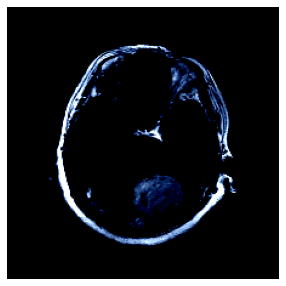

In [89]:
show(img)

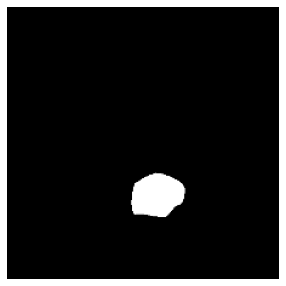

In [90]:
show(mask.reshape((224,224)))

In [91]:
x_tensor = torch.from_numpy(img).to(DEVICE).unsqueeze(0)

In [92]:
pr_mask = best_model.predict(x_tensor)

In [93]:
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

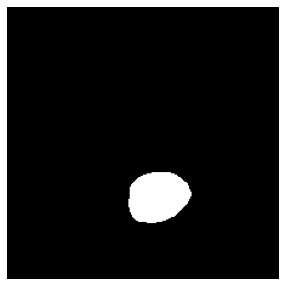

In [94]:
show(pr_mask)